# Cross-Lingual Transferability of Voice Analysis Models: a Parkinson's Disease Case Study

## Preliminaries

### Imports

In [1]:
from typing import Tuple, List, Dict, Union, Optional

In [2]:
import os
from ast import literal_eval
import datetime

In [3]:
import numpy as np
import pandas as pd
import librosa

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [5]:
EN_DATA_DIR: str = '../resources/data/preprocessed/en'
EN_METADATA_FILE: str = '../resources/data/preprocessed/en/metadata.csv'
TE_DATA_DIR: str = '../resources/data/preprocessed/te'
TE_METADATA_FILE: str = '../resources/data/preprocessed/te/metadata.csv'

In [31]:
EN_TO_TE_EXPERIMENTS_DIR: str = '../experiments/experiment_2023_02_03_10_55_53/'
TE_TO_EN_EXPERIMENTS_DIR: str = '../experiments/...'

In [7]:
OUT_DIR_PATH: str = '../experiments/results'
if not os.path.exists(OUT_DIR_PATH):
    os.mkdir(OUT_DIR_PATH)

In [8]:
LABEL_MAPPING: Dict[str, str] = {
    'healthy': 'Healthy conditions',
    'unhealthy': 'Parkinson\'s disease'
}
FEATURES_MAPPING: Dict[str, str] = {
    'spectral': 'Prosodic and Acoustic',
    'vggish': 'VGGish',
    'soundnet': 'SoundNet',
    'wav2vec': 'Wav2Vec 2.0'
}
POOLING_MAPPING: Dict[str, str] = {
    'avg': 'Avg. pooling',
    'max': 'Max pooling',
    'flatten': 'Flattening'
}
ADAPTATION_MAPPING: Dict[bool, str] = {
    False: 'None',
    True: 'Deep CORAL'  # 'CORrelation ALignment (CORAL)'
}
DATA_MAPPING: Dict[str, str] = {
    'src': 'Source data (test split)',
    'tgt': 'Target data'
}
METRICS_MAPPING: Dict[str, str] = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore': '$F_1$-score',
    'specificity': 'Specificity',
    'roc_auc': 'ROC AUC',
    'support': 'Support',
    'fpr': 'False positives rate',
    'tpr': 'True postives rate',
    'roc_thresholds': 'Threshold (from ROC curve)',
    'precisions': 'Precision score',
    'recalls': 'Recall score',
    'pr_rc_thresholds': 'Threshold (from precision-recall curve)',
    'confusion_matrix': 'Confusion matrix'
}

In [9]:
METRICS = ['Accuracy', 'Precision', 'Recall', '$F_1$-score', 'Specificity', 'ROC AUC']
ROC = ['False positives rate', 'True postives rate', 'Threshold (from ROC curve)']
PRC_REC = ['Precision score', 'Recall score', 'Threshold (from precision-recall curve)']
CONF_MAT = ['Confusion matrix']

In [10]:
DF_COLUMNS: List[str] = ['Input features', 'Pooling approach', 'Domain adaptation', 'Data set', 'Metric', 'Value']

### Utility function(s)

In [11]:
def get_duration(path: str) -> Optional[float]:
    if os.path.exists(path):
        return librosa.get_duration(filename=path)
    else:
        return None

In [12]:
def convert_series(raw_series: pd.Series) -> Tuple[
    str, str, str, str, str, Union[float, int, List[float], List[List[int]]]
]:
    feature: str = FEATURES_MAPPING[raw_series['feature']]
    pooling: str = POOLING_MAPPING[raw_series['pooling']]
    adaptation: str = ADAPTATION_MAPPING[raw_series['adaptation']]
    data: str = DATA_MAPPING[raw_series['data_set']]
    metric: str = METRICS_MAPPING[raw_series['metric']]
    try:
        value = literal_eval(raw_series['value'])
    except:
        value = None
    
    return feature, pooling, adaptation, data, metric, value

In [13]:
def convert_results_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(
        [convert_series(row) for _, row in raw_df.iterrows()], columns=DF_COLUMNS
    )

    return df

## Data

Load data

In [14]:
df_en_metadata: pd.DataFrame = pd.read_csv(EN_METADATA_FILE, )
df_en_metadata['Language'] = 'English'
df_en_metadata['Label'] = df_en_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_en_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
167,ReadText_PD_ID02_pd_2_0_0_000.wav,unhealthy,ReadText/PD/ID02_pd_2_0_0.wav,00:00:23.000,00:00:34.000,English,Parkinson's disease
229,ReadText_PD_ID18_pd_4_3_3_005.wav,unhealthy,ReadText/PD/ID18_pd_4_3_3.wav,00:01:09.000,00:01:22.000,English,Parkinson's disease
39,ReadText_HC_ID09_hc_0_0_0_001.wav,healthy,ReadText/HC/ID09_hc_0_0_0.wav,00:00:42.000,00:00:49.000,English,Healthy conditions
247,ReadText_PD_ID27_pd_4_1_1_001.wav,unhealthy,ReadText/PD/ID27_pd_4_1_1.wav,00:00:34.000,00:00:47.000,English,Parkinson's disease
102,ReadText_HC_ID21_hc_0_0_0_007.wav,healthy,ReadText/HC/ID21_hc_0_0_0.wav,00:01:49.000,00:02:00.000,English,Healthy conditions
5,ReadText_HC_ID00_hc_0_0_0_005.wav,healthy,ReadText/HC/ID00_hc_0_0_0.wav,00:01:17.000,00:01:28.000,English,Healthy conditions
401,SpontaneousDialogue_PD_ID06_pd_3_1_1_004.wav,unhealthy,SpontaneousDialogue/PD/ID06_pd_3_1_1.wav,00:01:42.000,00:01:53.000,English,Parkinson's disease
324,SpontaneousDialogue_HC_ID10_hc_0_0_0_003.wav,healthy,SpontaneousDialogue/HC/ID10_hc_0_0_0.wav,00:02:00.000,00:02:10.000,English,Healthy conditions
263,ReadText_PD_ID30_pd_2_1_1_005.wav,unhealthy,ReadText/PD/ID30_pd_2_1_1.wav,00:01:18.000,00:01:32.000,English,Parkinson's disease
297,SpontaneousDialogue_HC_ID01_hc_0_0_0_003.wav,healthy,SpontaneousDialogue/HC/ID01_hc_0_0_0.wav,00:01:02.000,00:01:13.000,English,Healthy conditions


In [16]:
df_te_metadata: pd.DataFrame = pd.read_csv(TE_METADATA_FILE)
df_te_metadata['Language'] = 'Telugu'
df_te_metadata['Label'] = df_te_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_te_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
152,te_in_female_tef_06625_00964019270_000.wav,healthy,te_in_female/tef_06625_00964019270.wav,NaN,NaN,Telugu,Healthy conditions
62,k venkata subbaiah voice_001.wav,unhealthy,k venkata subbaiah voice.wav,00:00:11.000,00:00:22.000,Telugu,Parkinson's disease
73,malakondaiah_002.wav,unhealthy,malakondaiah.wav,00:00:26.000,00:00:32.000,Telugu,Parkinson's disease
3,AUD-20210525-WA0024_000.wav,unhealthy,AUD-20210525-WA0024.wav,00:00:07.000,00:00:11.000,Telugu,Parkinson's disease
112,te_in_female_tef_04261_00307569200_000.wav,healthy,te_in_female/tef_04261_00307569200.wav,NaN,NaN,Telugu,Healthy conditions
48,PTT-20210524-WA0021_002.wav,unhealthy,PTT-20210524-WA0021.wav,00:00:47.000,00:00:54.000,Telugu,Parkinson's disease
158,te_in_female_tef_06869_02026027387_000.wav,healthy,te_in_female/tef_06869_02026027387.wav,NaN,NaN,Telugu,Healthy conditions
110,te_in_female_tef_04213_00722043109_000.wav,healthy,te_in_female/tef_04213_00722043109.wav,NaN,NaN,Telugu,Healthy conditions
226,te_in_male_tem_03338_01021619636_000.wav,healthy,te_in_male/tem_03338_01021619636.wav,NaN,NaN,Telugu,Healthy conditions
56,PTT-20210611-WA0000_000.wav,unhealthy,PTT-20210611-WA0000.wav,00:00:01.000,00:00:09.000,Telugu,Parkinson's disease


In [18]:
df_metadata = pd.concat([df_en_metadata, df_te_metadata]).reset_index()

df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label
23,23,ReadText_HC_ID03_hc_0_0_0_004.wav,healthy,ReadText/HC/ID03_hc_0_0_0.wav,00:01:35.000,00:01:45.000,English,Healthy conditions
52,52,ReadText_HC_ID11_hc_0_0_0_000.wav,healthy,ReadText/HC/ID11_hc_0_0_0.wav,00:00:28.000,00:00:40.000,English,Healthy conditions
384,384,SpontaneousDialogue_HC_ID36_hc_0_0_0_000.wav,healthy,SpontaneousDialogue/HC/ID36_hc_0_0_0.wav,00:00:15.000,00:00:28.000,English,Healthy conditions
465,0,AUD-20210515-WA0002_000.wav,unhealthy,AUD-20210515-WA0002.wav,00:00:07.000,00:00:16.000,Telugu,Parkinson's disease
281,281,ReadText_PD_ID34_pd_2_0_0_001.wav,unhealthy,ReadText/PD/ID34_pd_2_0_0.wav,00:00:37.000,00:00:46.000,English,Parkinson's disease
592,127,te_in_female_tef_05181_01132322895_000.wav,healthy,te_in_female/tef_05181_01132322895.wav,NaN,NaN,Telugu,Healthy conditions
299,299,SpontaneousDialogue_HC_ID03_hc_0_0_0_000.wav,healthy,SpontaneousDialogue/HC/ID03_hc_0_0_0.wav,00:00:37.000,00:00:50.000,English,Healthy conditions
554,89,te_in_female_tef_01908_00287699580_000.wav,healthy,te_in_female/tef_01908_00287699580.wav,NaN,NaN,Telugu,Healthy conditions
601,136,te_in_female_tef_05691_01425196827_000.wav,healthy,te_in_female/tef_05691_01425196827.wav,NaN,NaN,Telugu,Healthy conditions
724,259,te_in_male_tem_08680_00657176993_000.wav,healthy,te_in_male/tem_08680_00657176993.wav,NaN,NaN,Telugu,Healthy conditions


Distribution of duration (in seconds) of audio files

In [19]:
df_metadata['Duration [s]'] = df_metadata.apply(
    lambda r: get_duration(os.path.join(EN_DATA_DIR if r['Language'] == 'English' else TE_DATA_DIR, r['file_name'])), axis=1
)
df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label,Duration [s]
283,283,ReadText_PD_ID34_pd_2_0_0_003.wav,unhealthy,ReadText/PD/ID34_pd_2_0_0.wav,00:01:04.000,00:01:14.000,English,Parkinson's disease,9.997619
617,152,te_in_female_tef_06625_00964019270_000.wav,healthy,te_in_female/tef_06625_00964019270.wav,NaN,NaN,Telugu,Healthy conditions,2.730667
192,192,ReadText_PD_ID06_pd_3_1_1_008.wav,unhealthy,ReadText/PD/ID06_pd_3_1_1.wav,00:02:40.000,00:02:49.000,English,Parkinson's disease,8.976190
113,113,ReadText_HC_ID23_hc_0_0_0_004.wav,healthy,ReadText/HC/ID23_hc_0_0_0.wav,00:01:53.000,00:02:07.000,English,Healthy conditions,14.021429
174,174,ReadText_PD_ID02_pd_2_0_0_007.wav,unhealthy,ReadText/PD/ID02_pd_2_0_0.wav,00:01:48.000,00:02:02.000,English,Parkinson's disease,13.990476
525,60,PTT-20210611-WA0000_004.wav,unhealthy,PTT-20210611-WA0000.wav,00:00:50.000,00:00:58.000,Telugu,Parkinson's disease,8.021333
172,172,ReadText_PD_ID02_pd_2_0_0_005.wav,unhealthy,ReadText/PD/ID02_pd_2_0_0.wav,00:01:12.000,00:01:23.000,English,Parkinson's disease,10.988095
563,98,te_in_female_tef_03689_00101186098_000.wav,healthy,te_in_female/tef_03689_00101186098.wav,NaN,NaN,Telugu,Healthy conditions,6.058667
202,202,ReadText_PD_ID07_pd_2_0_0_008.wav,unhealthy,ReadText/PD/ID07_pd_2_0_0.wav,00:01:59.000,00:02:09.000,English,Parkinson's disease,9.997619
83,83,ReadText_HC_ID15_hc_0_0_0_005.wav,healthy,ReadText/HC/ID15_hc_0_0_0.wav,00:01:55.000,00:02:04.000,English,Healthy conditions,9.007143


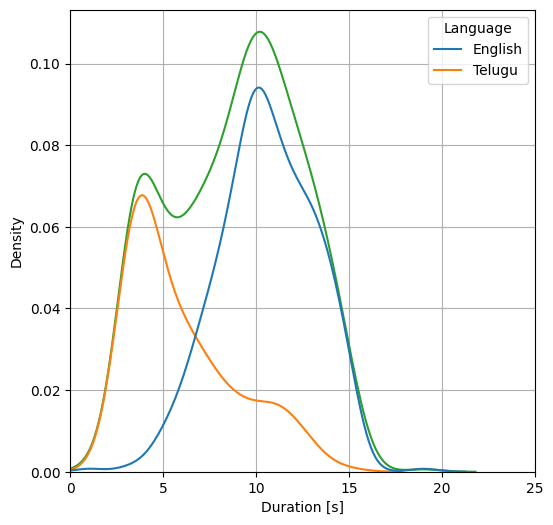

In [20]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata, x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata, x='Duration [s]', hue='Language' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [21]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration.pdf'))

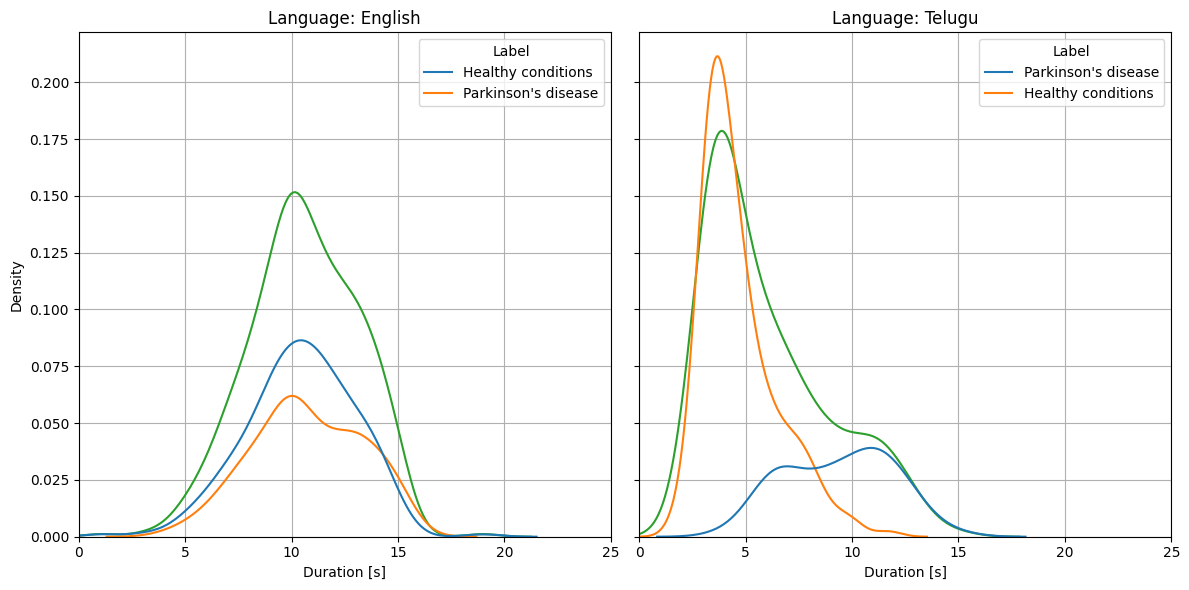

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, (language) in enumerate(['English', 'Telugu']):
    sns.kdeplot(data=df_metadata[df_metadata['Language'] == language], x='Duration [s]', color='tab:green', ax=axes[i])
    sns.kdeplot(
        data=df_metadata[df_metadata['Language'] == language],
        x='Duration [s]',
        hue='Label',
        color=['tab:red', 'tab:blue'],
        ax=axes[i]
    )
    plt.xlabel('Duration [s]')
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Duration [s]')
    axes[i].grid()
    axes[i].set_xlim(0, 25)

plt.tight_layout()
plt.show()


In [23]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_lang.pdf'))

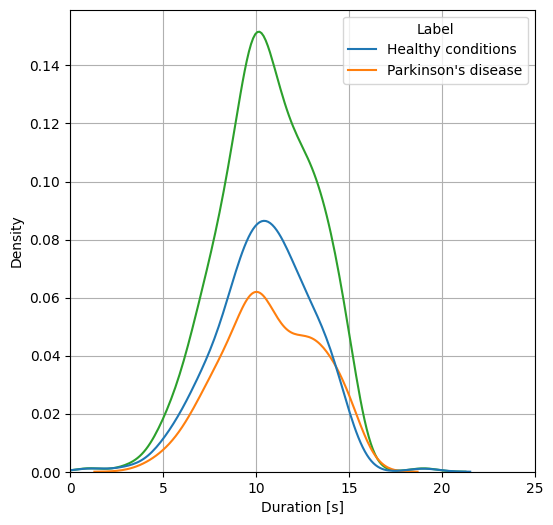

In [24]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:blue'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [25]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_en.pdf'))

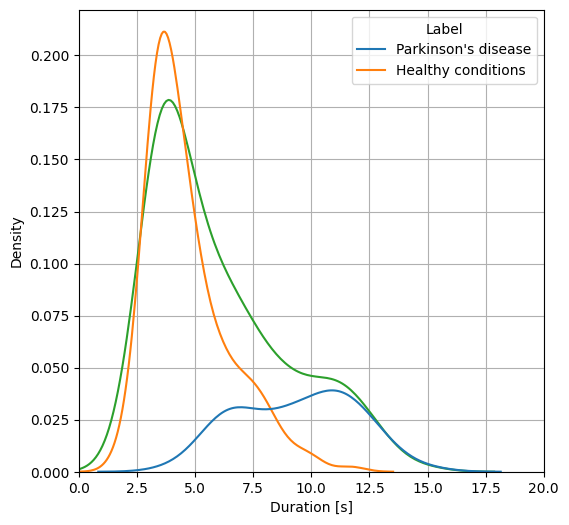

In [26]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Telugu'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Telugu'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 20)
plt.grid()

plt.show()

In [27]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_te.pdf'))

Cumulative durations

In [28]:
print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata['Duration [s]'].sum())}")
print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] == 'Healthy conditions']['Duration [s]'].sum())}")
print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] != 'Healthy conditions']['Duration [s]'].sum())}")

Total time [s]:                        1:49:14.816667
Healthy patients time [s]:             1:00:57.694095
Parkinson's disease patients time [s]: 0:48:17.122571


In [29]:
for language in ['English', 'Telugu']:
    print(language)
    print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata[df_metadata['Language'] == language]['Duration [s]'].sum())}")
    print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] == 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] != 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print('\n')

English
Total time [s]:                        1:21:03.083333
Healthy patients time [s]:             0:45:25.171429
Parkinson's disease patients time [s]: 0:35:37.911905


Telugu
Total time [s]:                        0:28:11.733333
Healthy patients time [s]:             0:15:32.522667
Parkinson's disease patients time [s]: 0:12:39.210667




## Results
Load DataFrames with results

In [37]:
df_en_to_te: pd.DataFrame = pd.read_csv(os.path.join(EN_TO_TE_EXPERIMENTS_DIR, 'scores.csv'))
df_en_to_te = convert_results_df(df_en_to_te)

In [28]:
df_te_to_en = pd.read_csv(os.path.join(TE_TO_EN_EXPERIMENTS_DIR, 'scores.csv'))
df_te_to_en = convert_results_df(df_te_to_en)
df_te_to_en.sample(10)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/experiment_2022_12_26_18_57_46/scores.csv'

### Detection in English

In [38]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & df_en_to_te['Metric'].isin(METRICS)]
# print(df)

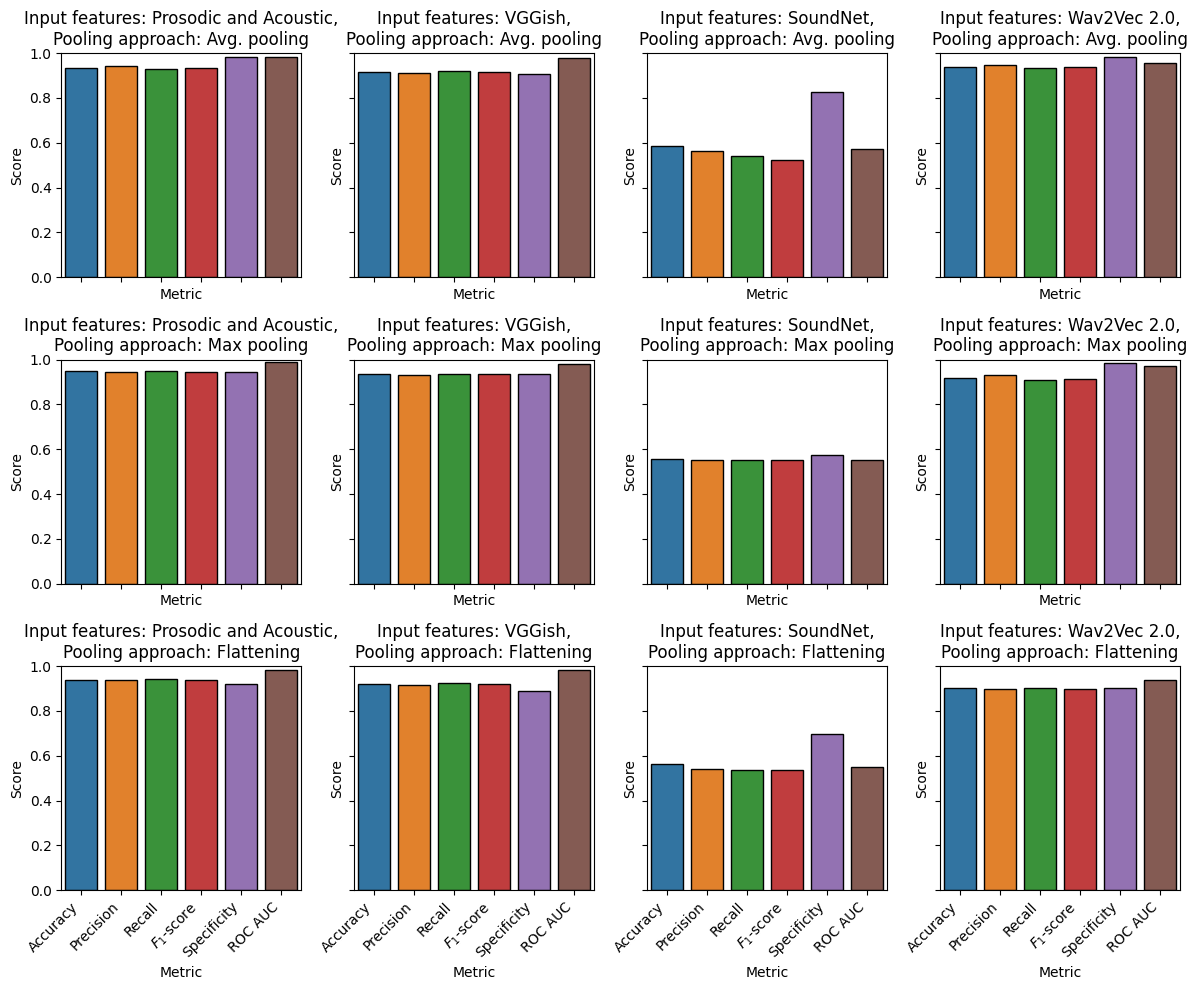

In [39]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cls_results.pdf'))

#### ROC curve

In [41]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(ROC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
400,SoundNet,Max pooling,None,Source data (test split),True postives rate,"[0.0, 0.007633587786259542, 0.0076335877862595..."
7,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005..."
232,VGGish,Max pooling,None,Source data (test split),True postives rate,"[0.0, 0.3712121212121212, 0.3787878787878788, ..."
623,Wav2Vec 2.0,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051813471502..."
343,SoundNet,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.005649717514124294, 0.005649..."
511,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.005181347150259067..."
569,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[2.0, 1.0, 0.9999999403953552, 0.9999998807907..."
9,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Threshold (from ROC curve),"[2.0, 1.0, 0.9999999403953552, 0.9999998807907..."
8,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),True postives rate,"[0.0, 0.11409395973154363, 0.1342281879194631,..."
176,VGGish,Avg. pooling,None,Source data (test split),True postives rate,"[0.0, 0.3560606060606061, 0.4015151515151515, ..."


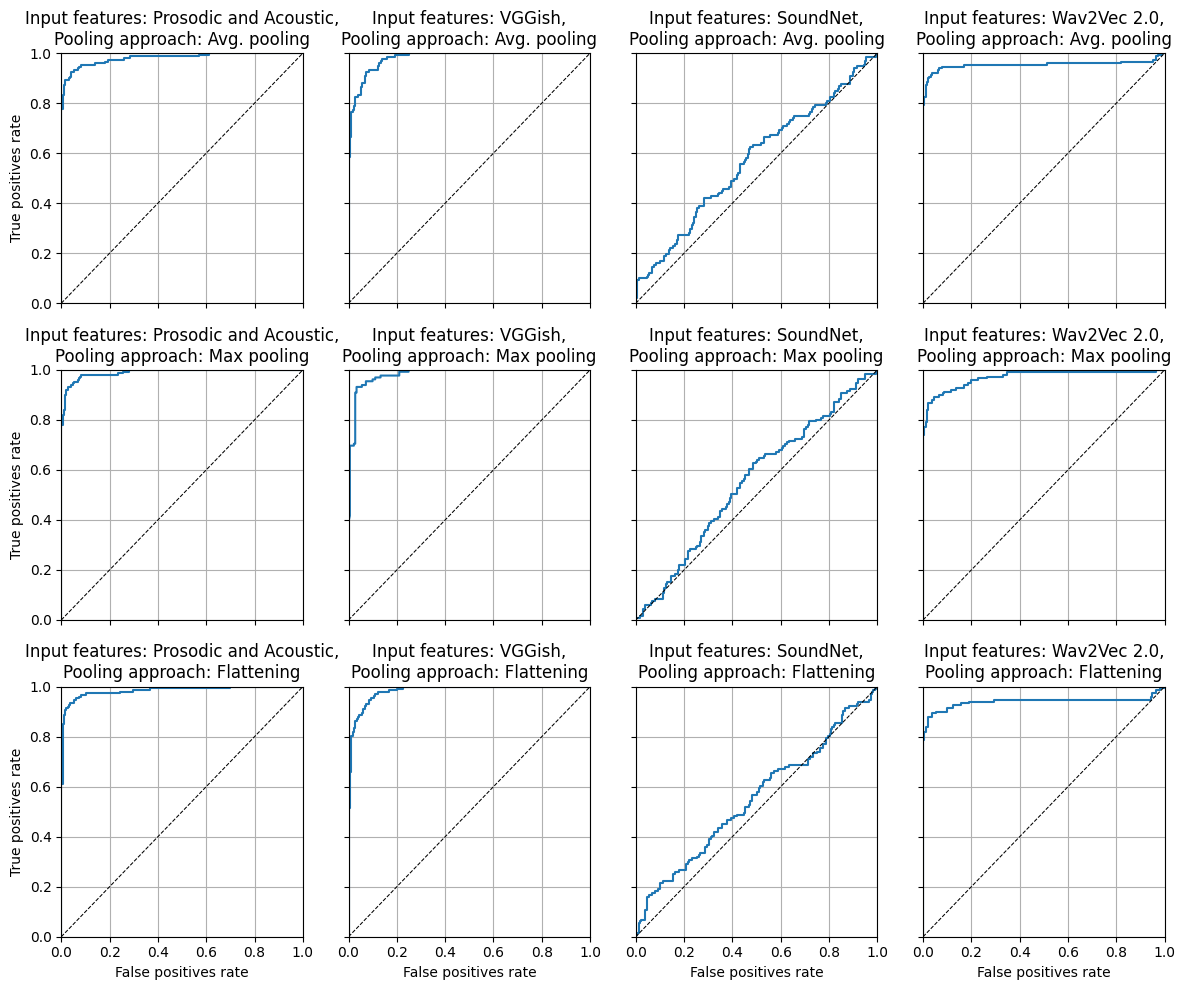

In [42]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_roc_curve.pdf'))

#### Precision-recall curve

In [44]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(PRC_REC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
570,Wav2Vec 2.0,Max pooling,None,Source data (test split),Precision score,"[0.43567251461988304, 0.436950146627566, 0.438..."
67,Prosodic and Acoustic,Max pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
11,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
122,Prosodic and Acoustic,Flattening,None,Source data (test split),Precision score,"[0.43567251461988304, 0.436950146627566, 0.438..."
572,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[2.5056895794350886e-11, 1.4290107230863214e-0..."
627,Wav2Vec 2.0,Flattening,None,Source data (test split),Recall score,"[1.0, 0.9932885906040269, 0.9932885906040269, ..."
292,VGGish,Flattening,None,Source data (test split),Threshold (from precision-recall curve),"[7.410824731657328e-10, 2.2628494633636365e-09..."
12,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[1.1391588827791566e-07, 2.2564486812370887e-0..."
516,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[1.4305339223418414e-37, 5.87228641343109e-31,..."
68,Prosodic and Acoustic,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[2.250805891890195e-06, 3.852926511171972e-06,..."


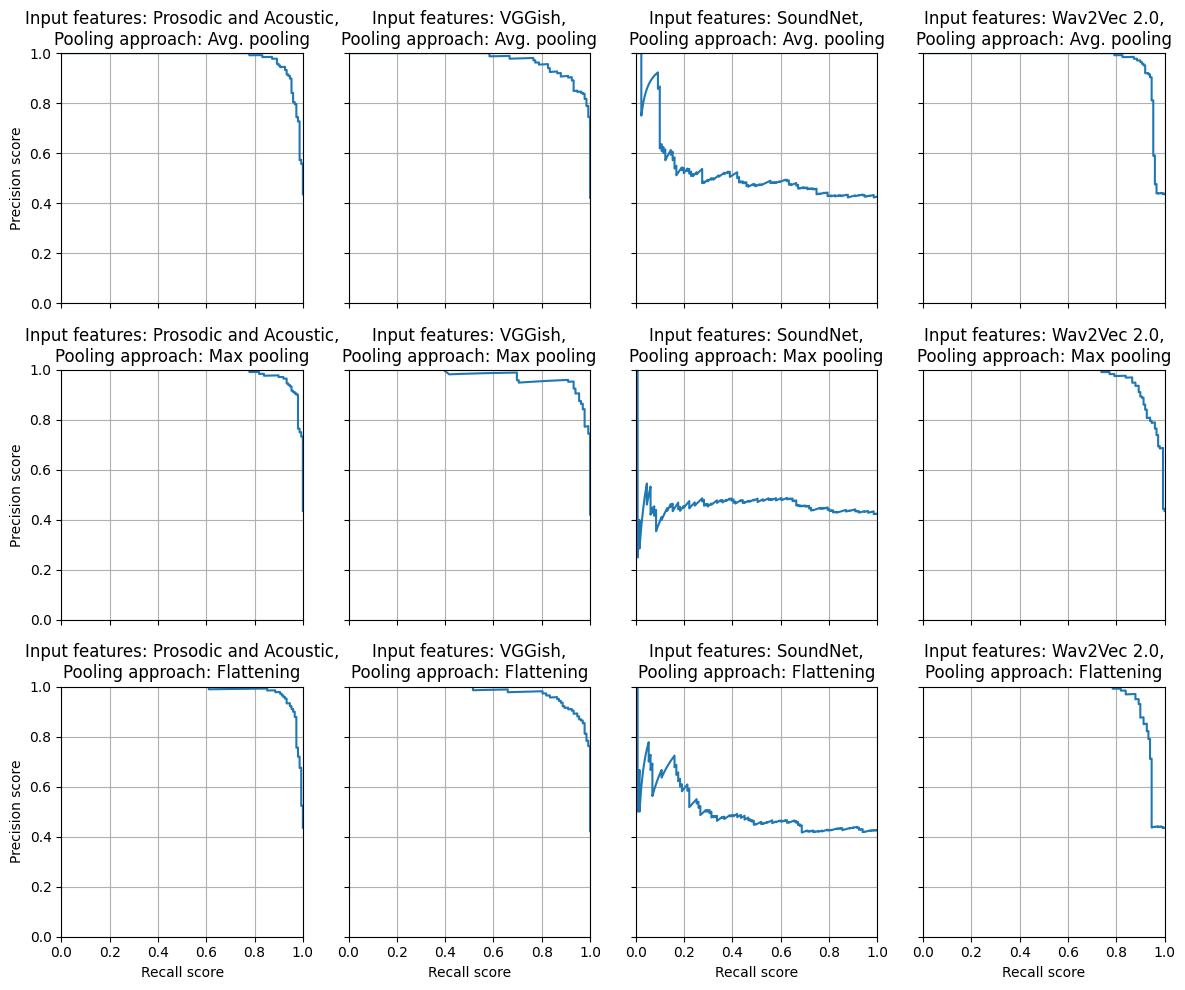

In [45]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [46]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_pr_curve.pdf'))

#### Confusion matrix

In [47]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(CONF_MAT))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
573,Wav2Vec 2.0,Max pooling,None,Source data (test split),Confusion matrix,"[[190, 3], [25, 124]]"
349,SoundNet,Avg. pooling,None,Source data (test split),Confusion matrix,"[[146, 31], [97, 34]]"
629,Wav2Vec 2.0,Flattening,None,Source data (test split),Confusion matrix,"[[174, 19], [15, 134]]"
405,SoundNet,Max pooling,None,Source data (test split),Confusion matrix,"[[102, 75], [62, 69]]"
237,VGGish,Max pooling,None,Source data (test split),Confusion matrix,"[[169, 12], [8, 124]]"
13,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Confusion matrix,"[[190, 3], [19, 130]]"
181,VGGish,Avg. pooling,None,Source data (test split),Confusion matrix,"[[164, 17], [9, 123]]"
461,SoundNet,Flattening,None,Source data (test split),Confusion matrix,"[[123, 54], [81, 50]]"
293,VGGish,Flattening,None,Source data (test split),Confusion matrix,"[[161, 20], [5, 127]]"
125,Prosodic and Acoustic,Flattening,None,Source data (test split),Confusion matrix,"[[178, 15], [6, 143]]"


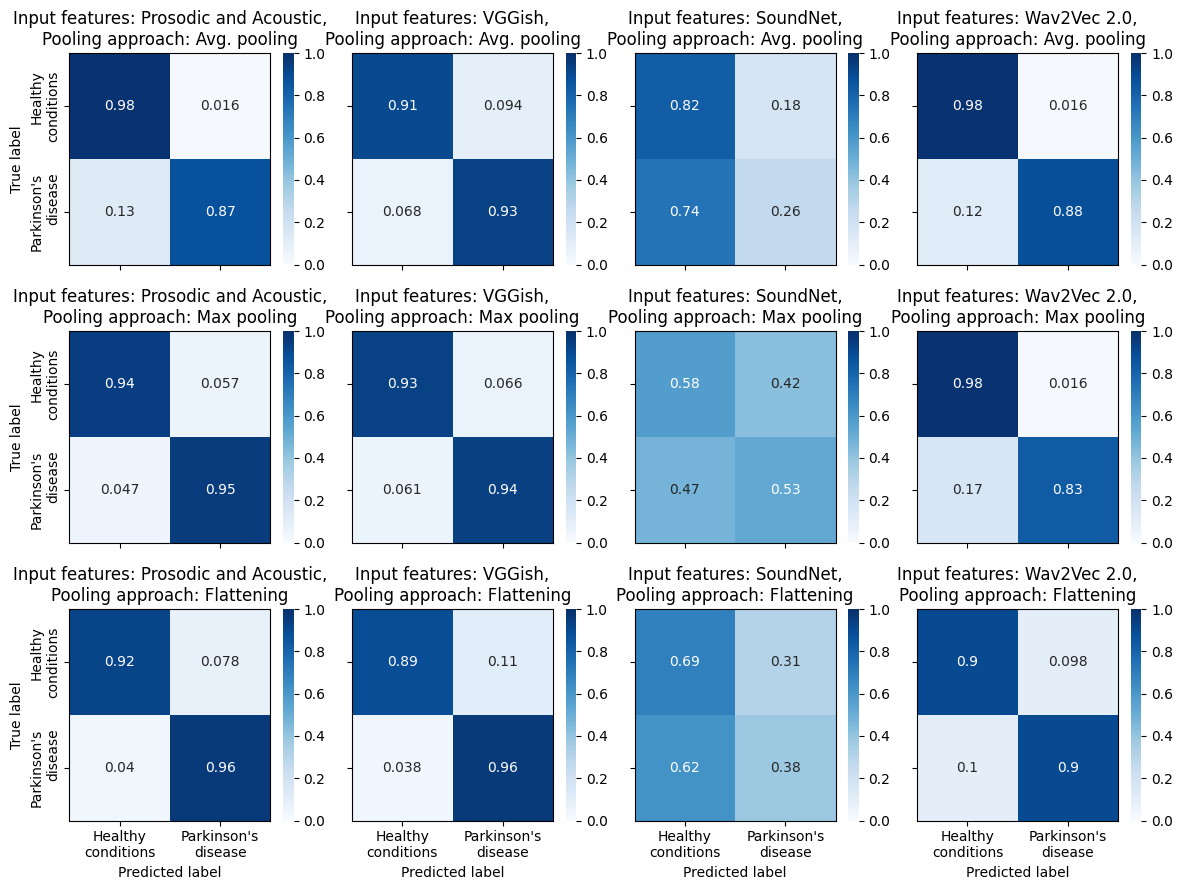

In [48]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [49]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cm.pdf'))

### Transferring from English to Hindi

In [50]:
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(METRICS))]
# print(df_no_ad)

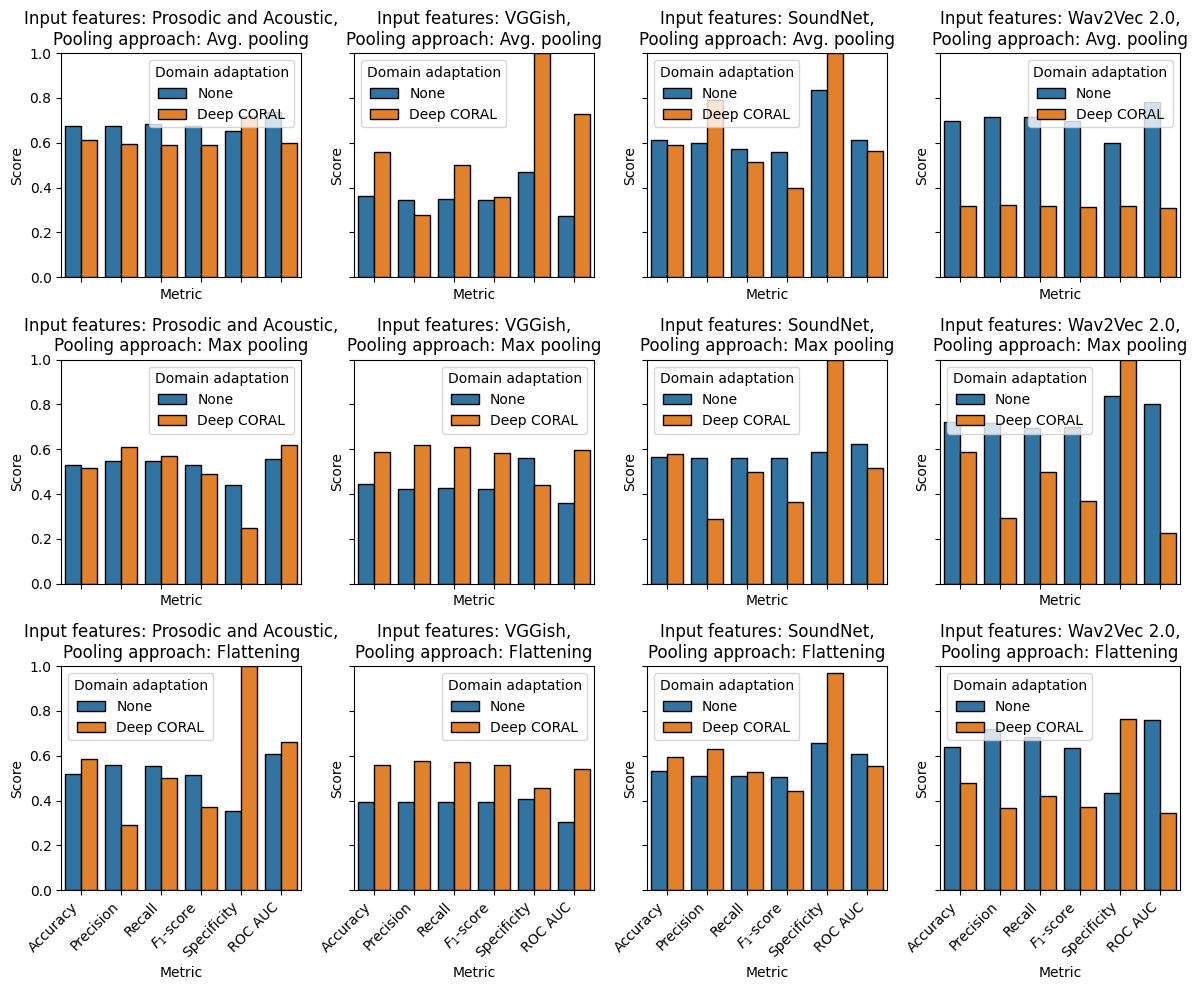

In [51]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [52]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_results.pdf'))

### ROC curve

In [53]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(ROC)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(ROC)]
# print(df_no_ad)

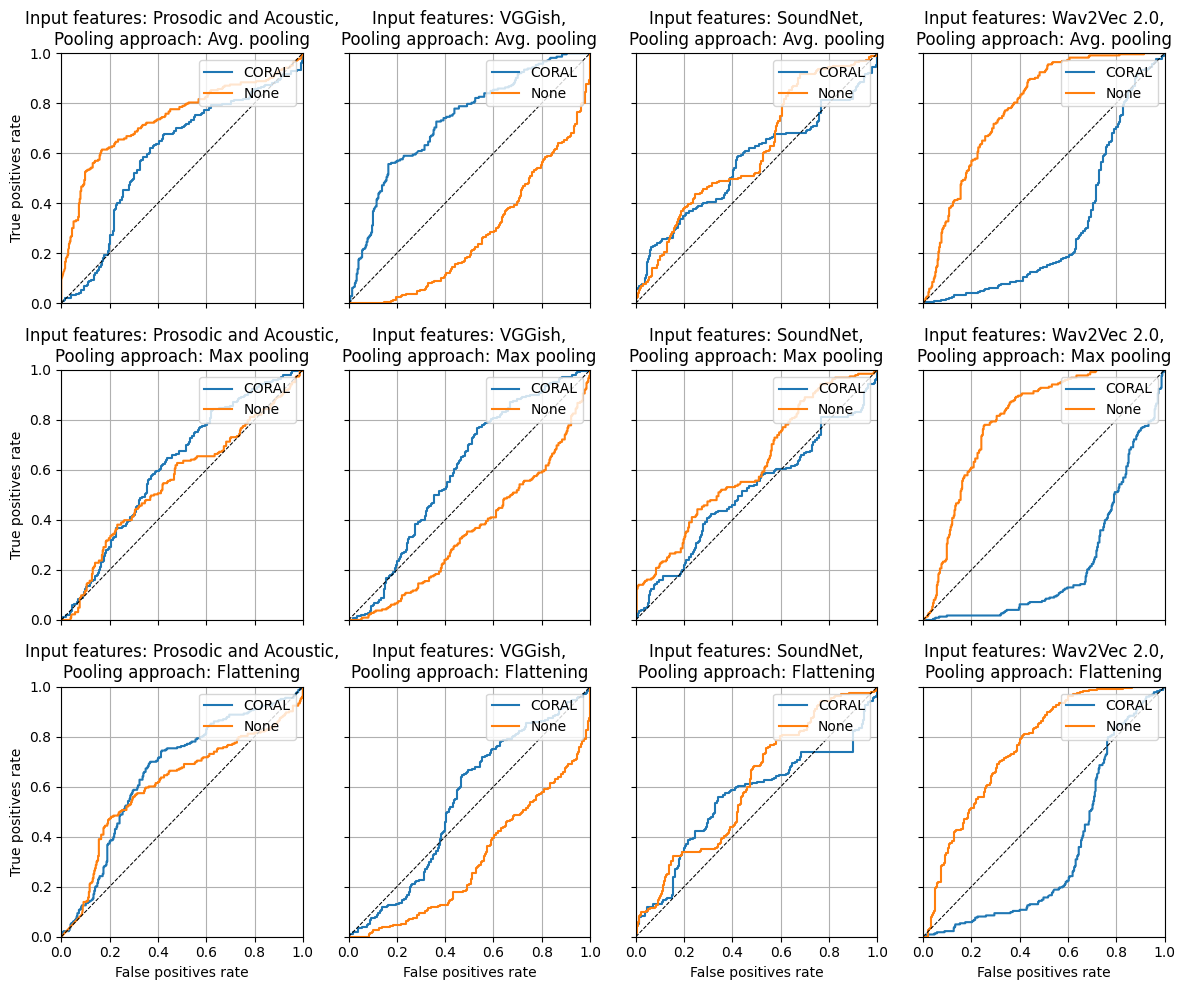

In [54]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [55]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_roc_curve.pdf'))

#### Precision-recall curve

In [56]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(PRC_REC)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(PRC_REC)]
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(PRC_REC))]
# print(df_no_ad)

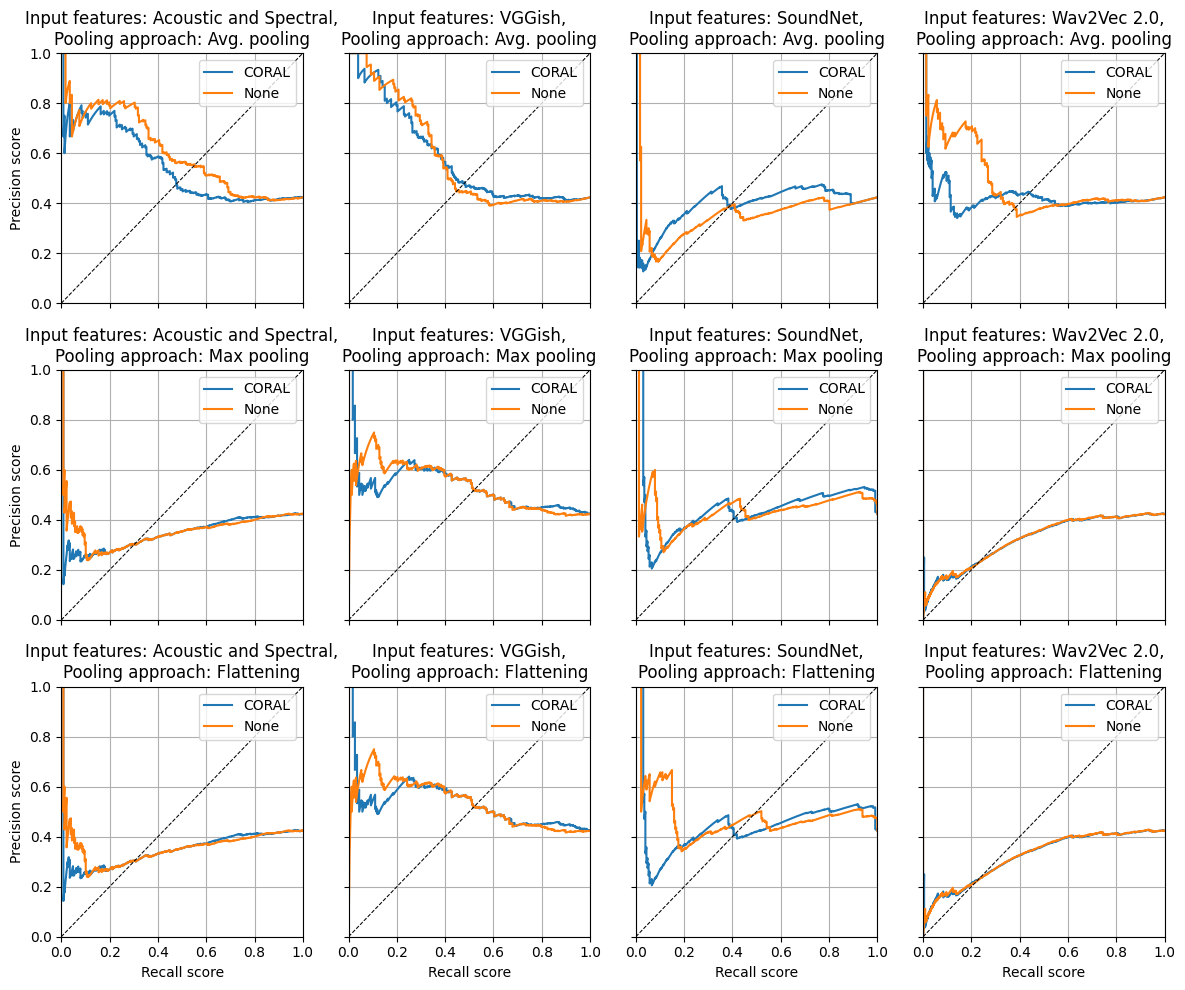

In [60]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        # axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_pr_curve.pdf'))

#### Confusion matrix

In [58]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(CONF_MAT)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(CONF_MAT)]
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(CONF_MAT))]
# print(df_no_ad)

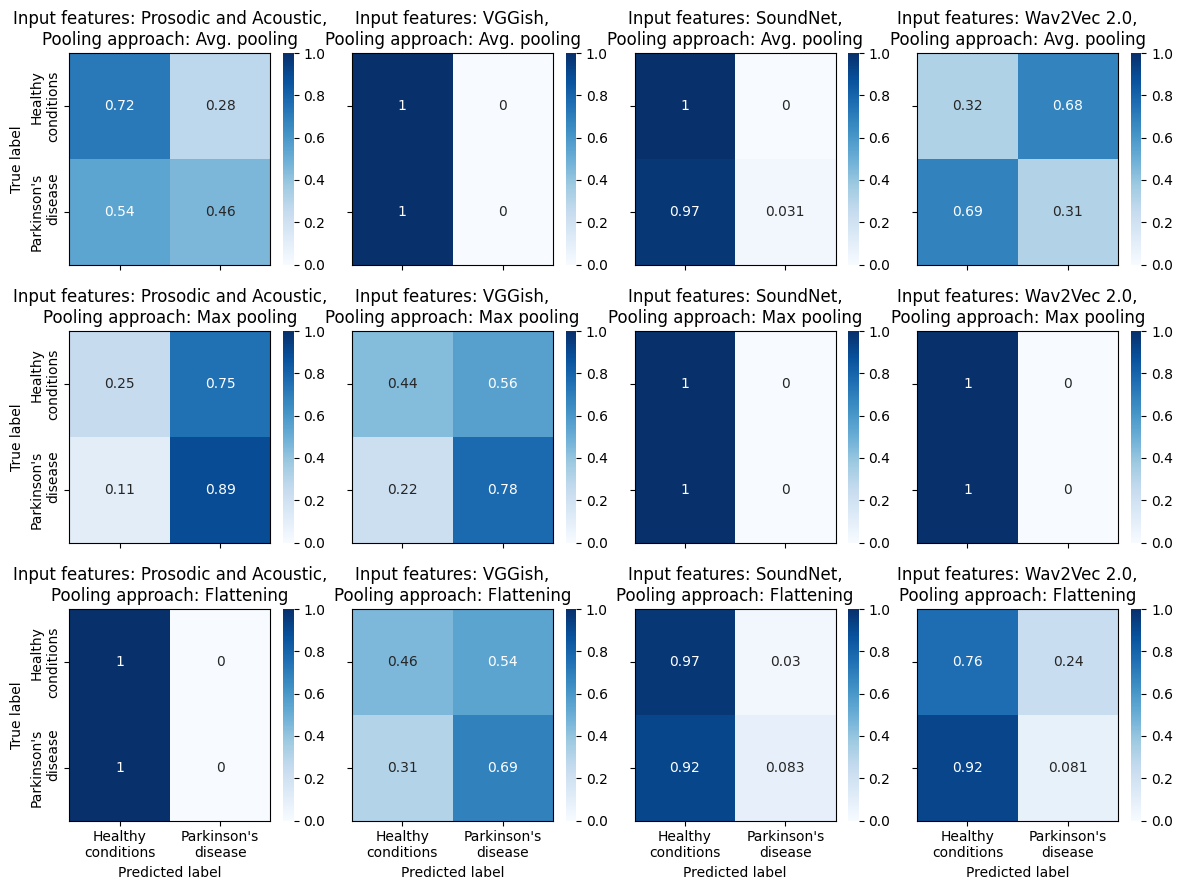

In [59]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [60]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_with_adpt_cm.pdf'))

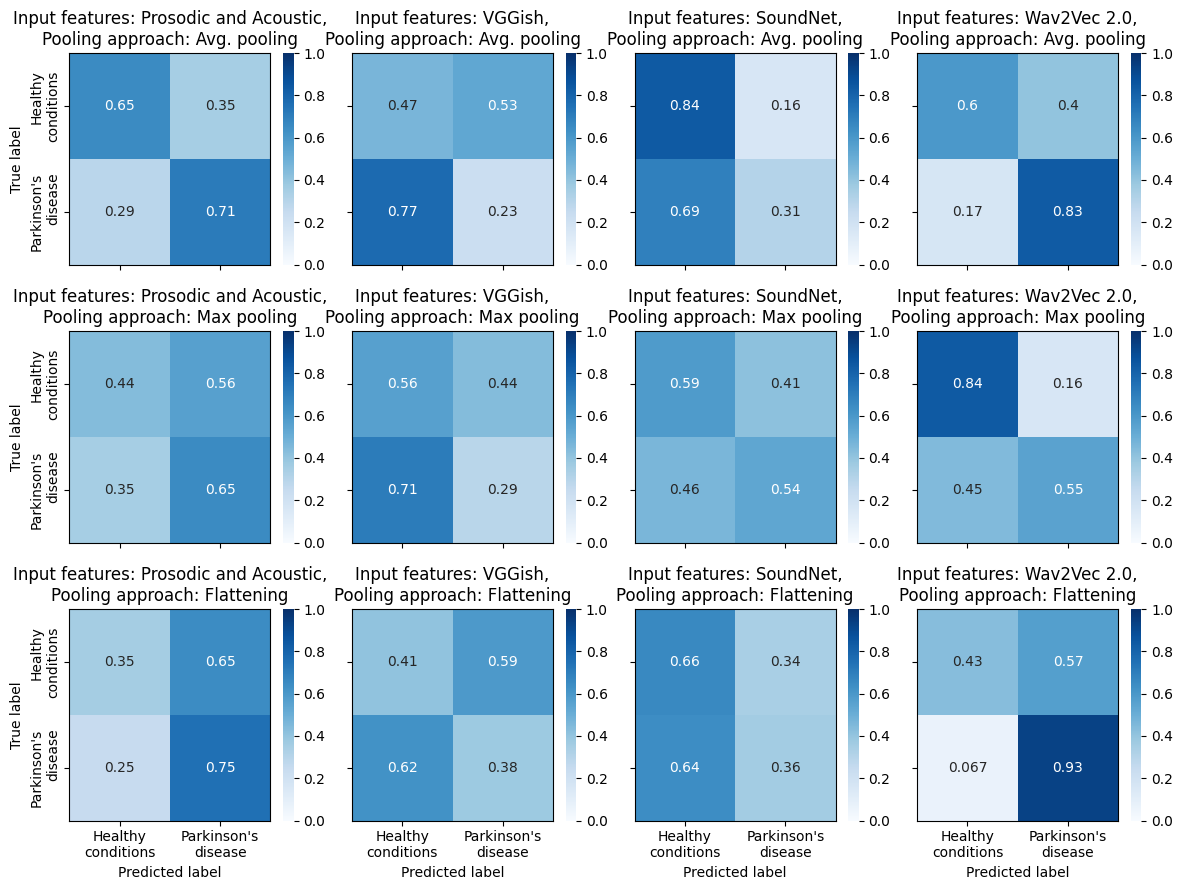

In [61]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [66]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_no_adpt_cm.pdf'))

### Detection in Hindi

In [67]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & df_te_to_en['Metric'].isin(METRICS)]
# print(df)

#### Metrics comparison

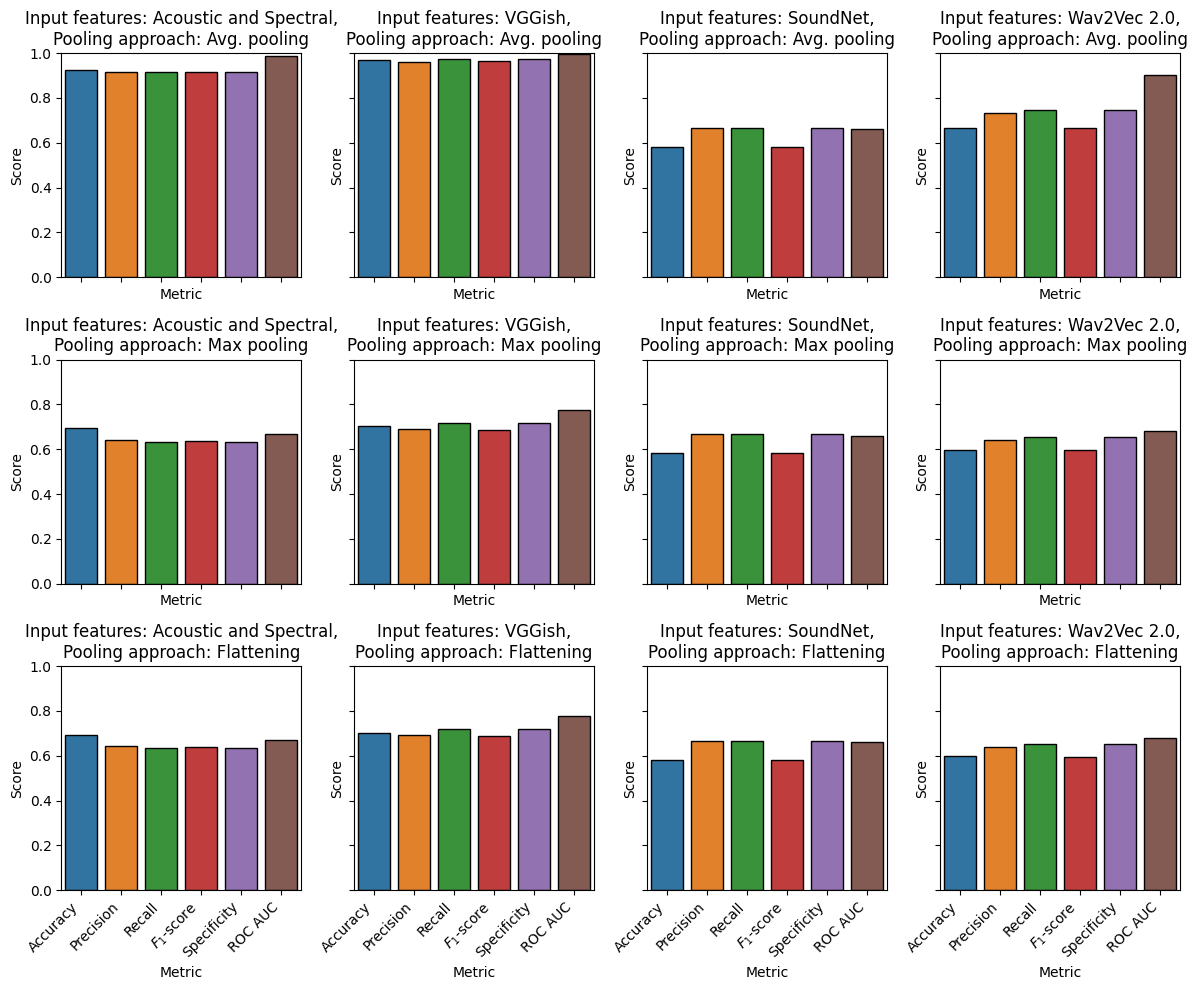

In [68]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [69]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_cls_results.pdf'))

#### ROC curve

In [70]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(ROC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
624,Wav2Vec 2.0,Flattening,None,Source data (test split),True postives rate,"[0.0, 0.0, 0.046511627906976744, 0.04651162790..."
568,Wav2Vec 2.0,Max pooling,None,Source data (test split),True postives rate,"[0.0, 0.0, 0.046511627906976744, 0.04651162790..."
399,SoundNet,Max pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.07692307692307693, 0.0769230..."
65,Acoustic and Spectral,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[1.8059755889038631, 0.8059755889038631, 0.805..."
232,VGGish,Max pooling,None,Source data (test split),True postives rate,"[0.0, 0.023255813953488372, 0.0465116279069767..."
457,SoundNet,Flattening,None,Source data (test split),Threshold (from ROC curve),"[1.6595651353084528, 0.6595651353084528, 0.576..."
233,VGGish,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[1.748833276990532, 0.7488332769905319, 0.7484..."
63,Acoustic and Spectral,Max pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.01098901098901099, 0.010989010989..."
567,Wav2Vec 2.0,Max pooling,None,Source data (test split),False positives rate,"[0.0, 0.01098901098901099, 0.01098901098901099..."
455,SoundNet,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.07692307692307693, 0.0769230..."


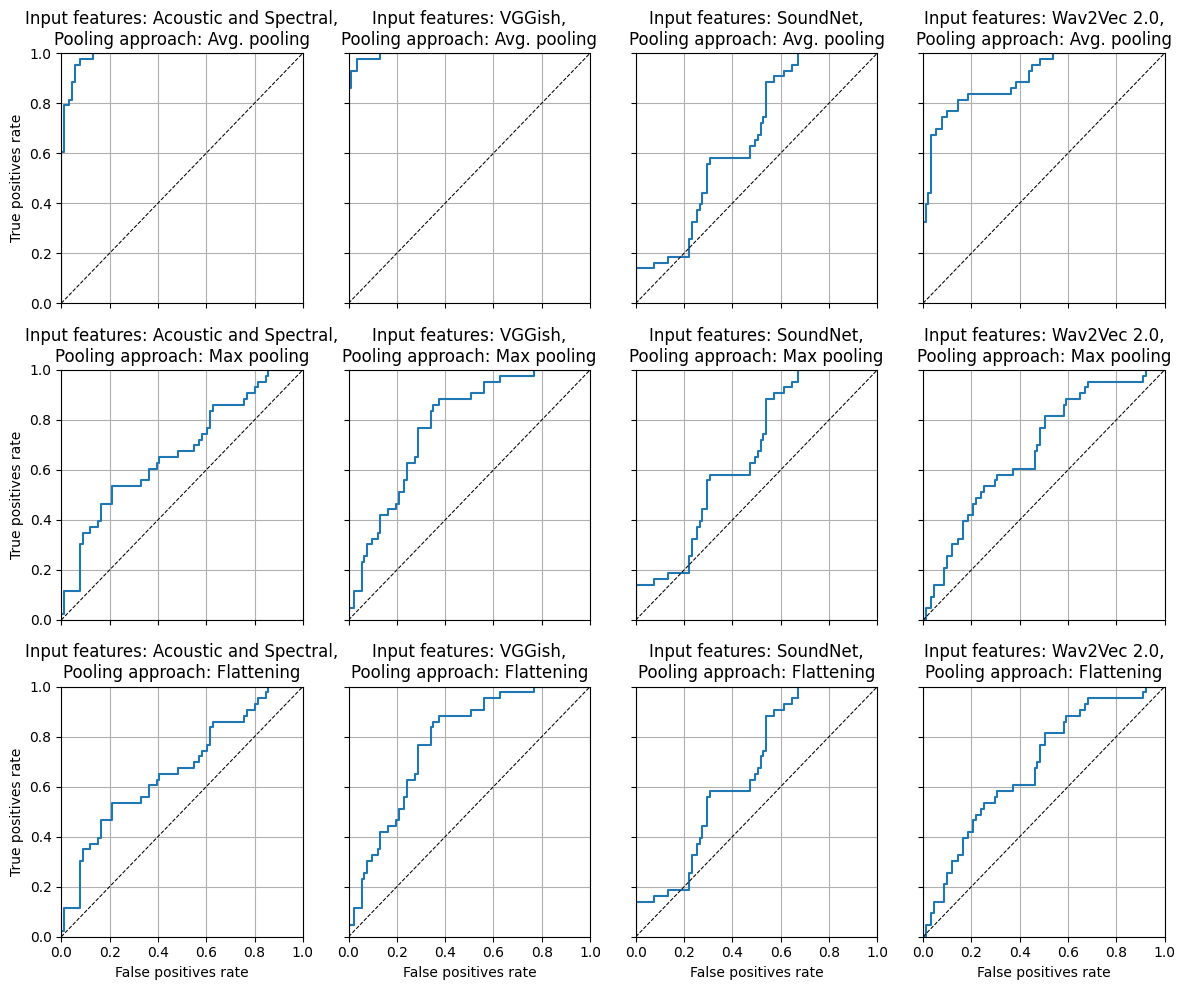

In [71]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [72]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_roc_curve.pdf'))

#### Precision-recall curve

In [73]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(PRC_REC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
291,VGGish,Flattening,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
236,VGGish,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.07567499808599205, 0.07744490330914146, 0.0..."
515,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
67,Acoustic and Spectral,Max pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
68,Acoustic and Spectral,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.289452389508641, 0.289477993614824, 0.28971..."
628,Wav2Vec 2.0,Flattening,None,Source data (test split),Threshold (from precision-recall curve),"[0.2095839803075304, 0.2097805089011362, 0.209..."
10,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Precision score,"[0.3208955223880597, 0.3233082706766917, 0.325..."
516,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.008203960688449677, 0.008313416990953334, 0..."
627,Wav2Vec 2.0,Flattening,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.976..."
572,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.20960128770850228, 0.20979779657771253, 0.2..."


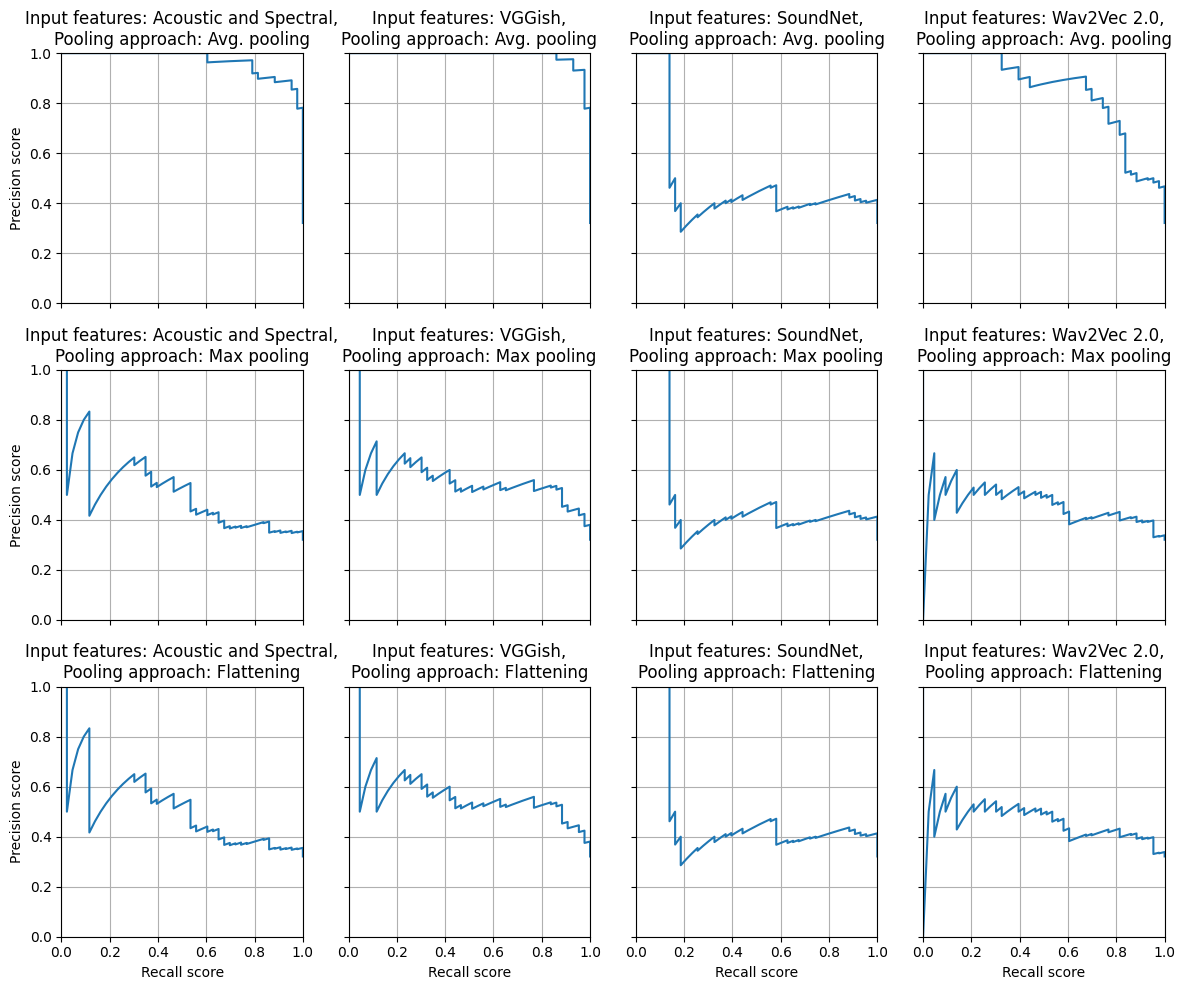

In [74]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [75]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_pr_curve.pdf'))

#### Confusion matrix

In [76]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(CONF_MAT))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
517,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Confusion matrix,"[[47, 44], [1, 42]]"
181,VGGish,Avg. pooling,None,Source data (test split),Confusion matrix,"[[88, 3], [1, 42]]"
237,VGGish,Max pooling,None,Source data (test split),Confusion matrix,"[[61, 30], [10, 33]]"
125,Acoustic and Spectral,Flattening,None,Source data (test split),Confusion matrix,"[[73, 18], [23, 20]]"
629,Wav2Vec 2.0,Flattening,None,Source data (test split),Confusion matrix,"[[45, 46], [8, 35]]"
13,Acoustic and Spectral,Avg. pooling,None,Source data (test split),Confusion matrix,"[[86, 5], [5, 38]]"
405,SoundNet,Max pooling,None,Source data (test split),Confusion matrix,"[[39, 52], [4, 39]]"
69,Acoustic and Spectral,Max pooling,None,Source data (test split),Confusion matrix,"[[73, 18], [23, 20]]"
349,SoundNet,Avg. pooling,None,Source data (test split),Confusion matrix,"[[39, 52], [4, 39]]"
573,Wav2Vec 2.0,Max pooling,None,Source data (test split),Confusion matrix,"[[45, 46], [8, 35]]"


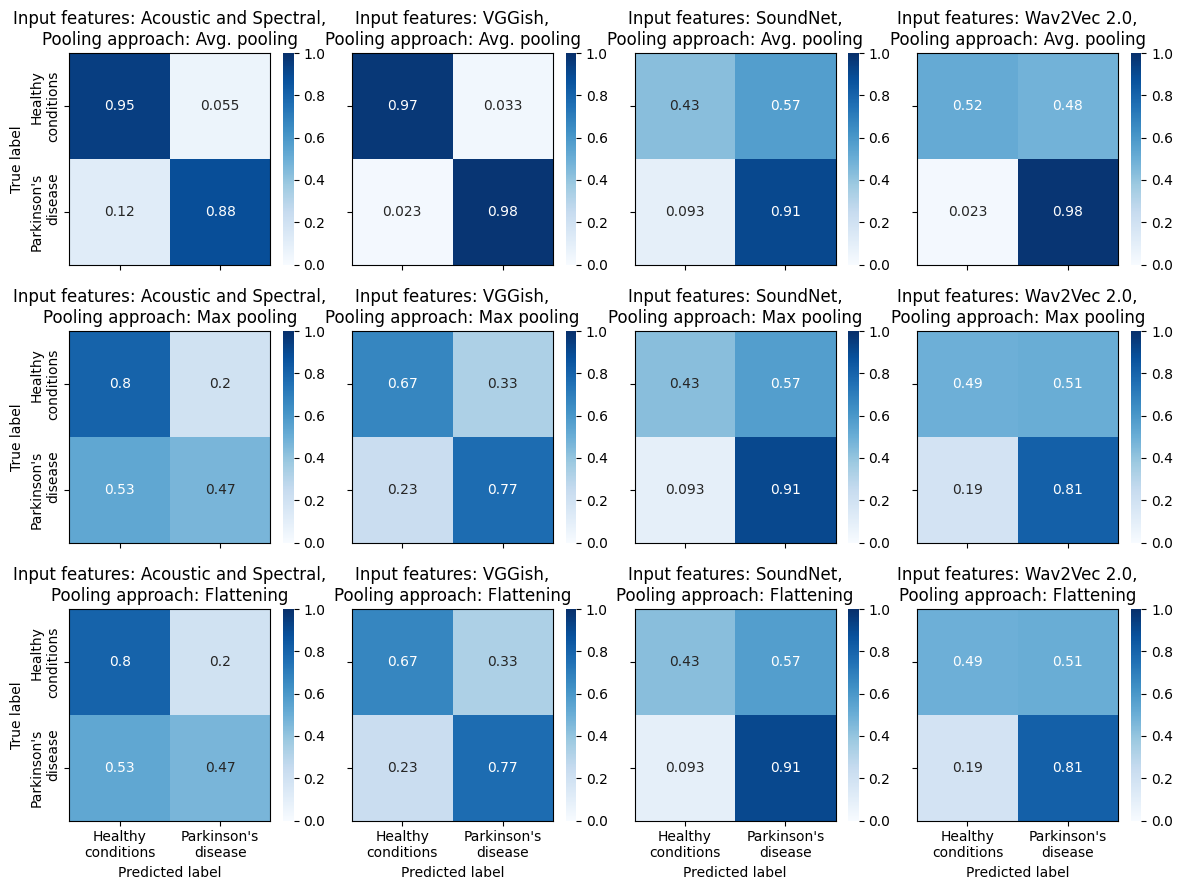

In [77]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [78]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cm.pdf'))

## Transferring from Hindi to English

In [79]:
df_all = df_te_to_en[
    (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & (df_te_to_en['Metric'].isin(METRICS))]
# print(df_all)

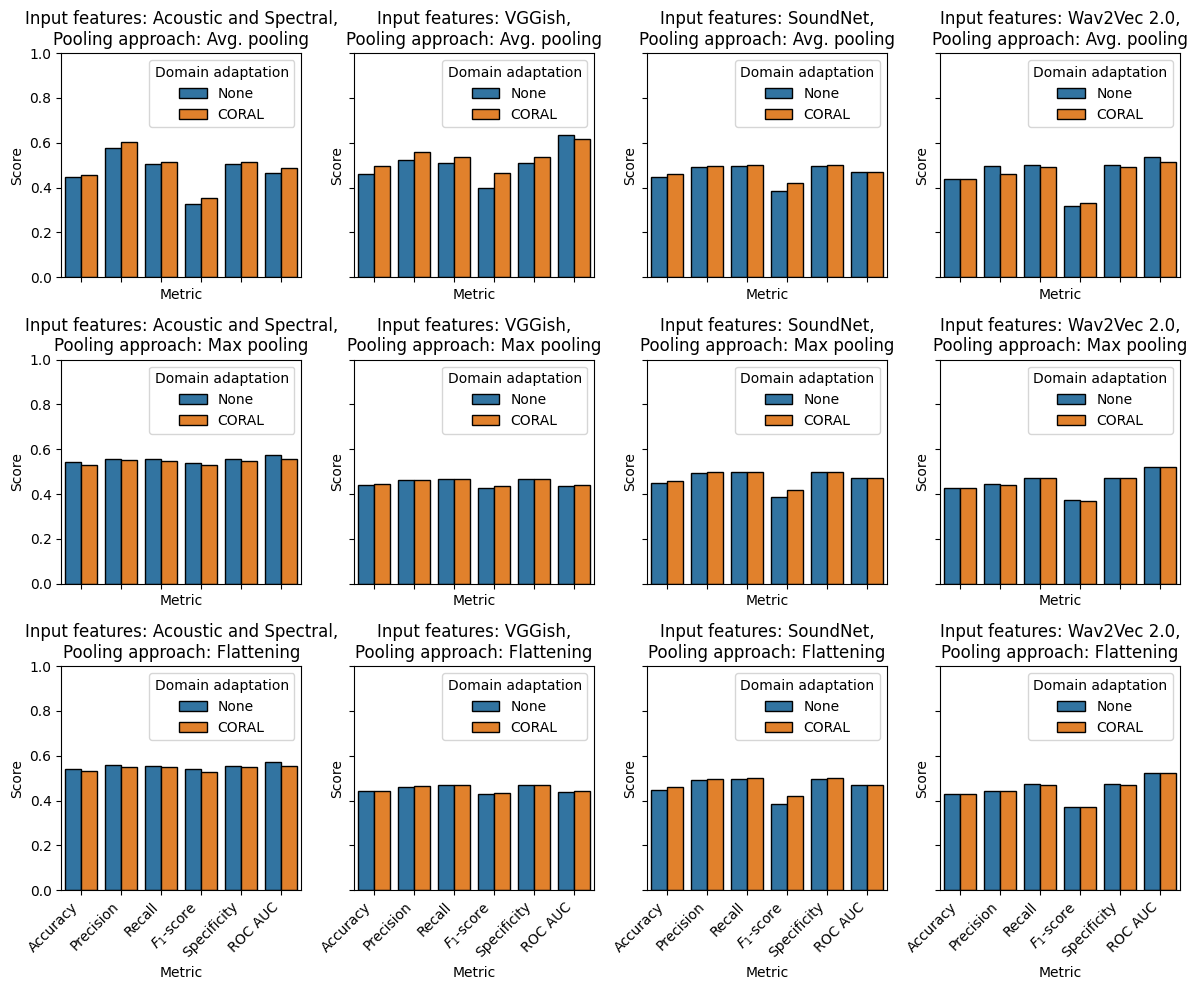

In [80]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [81]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_results.pdf'))

### ROC Curve

In [82]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(ROC)]
df_no_ad = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(ROC)]


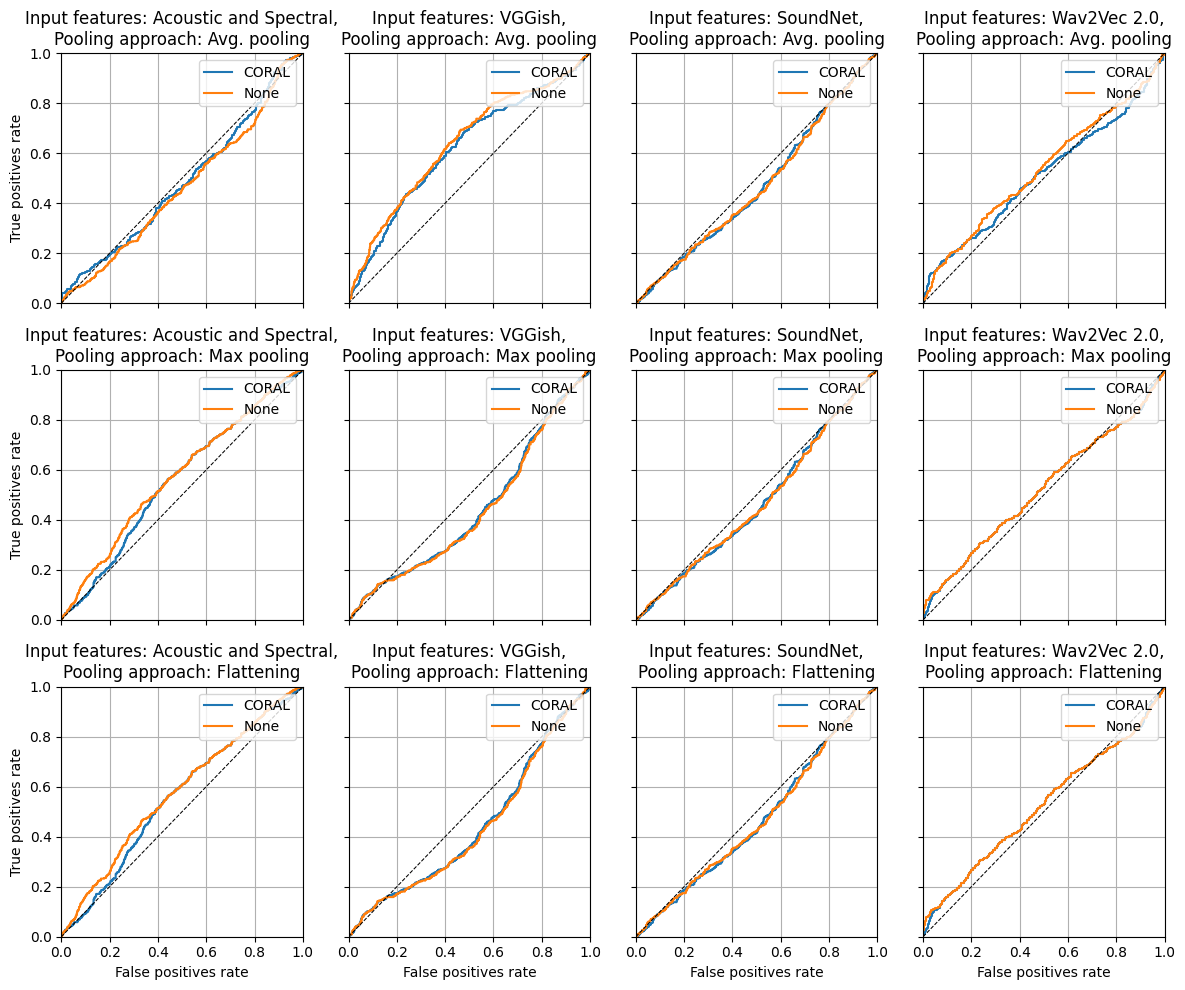

In [83]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [84]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_roc_curve.pdf'))

### Precision-recall curve

In [85]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(PRC_REC)]
df_no_ad = df_te_to_en[
     (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(PRC_REC)]


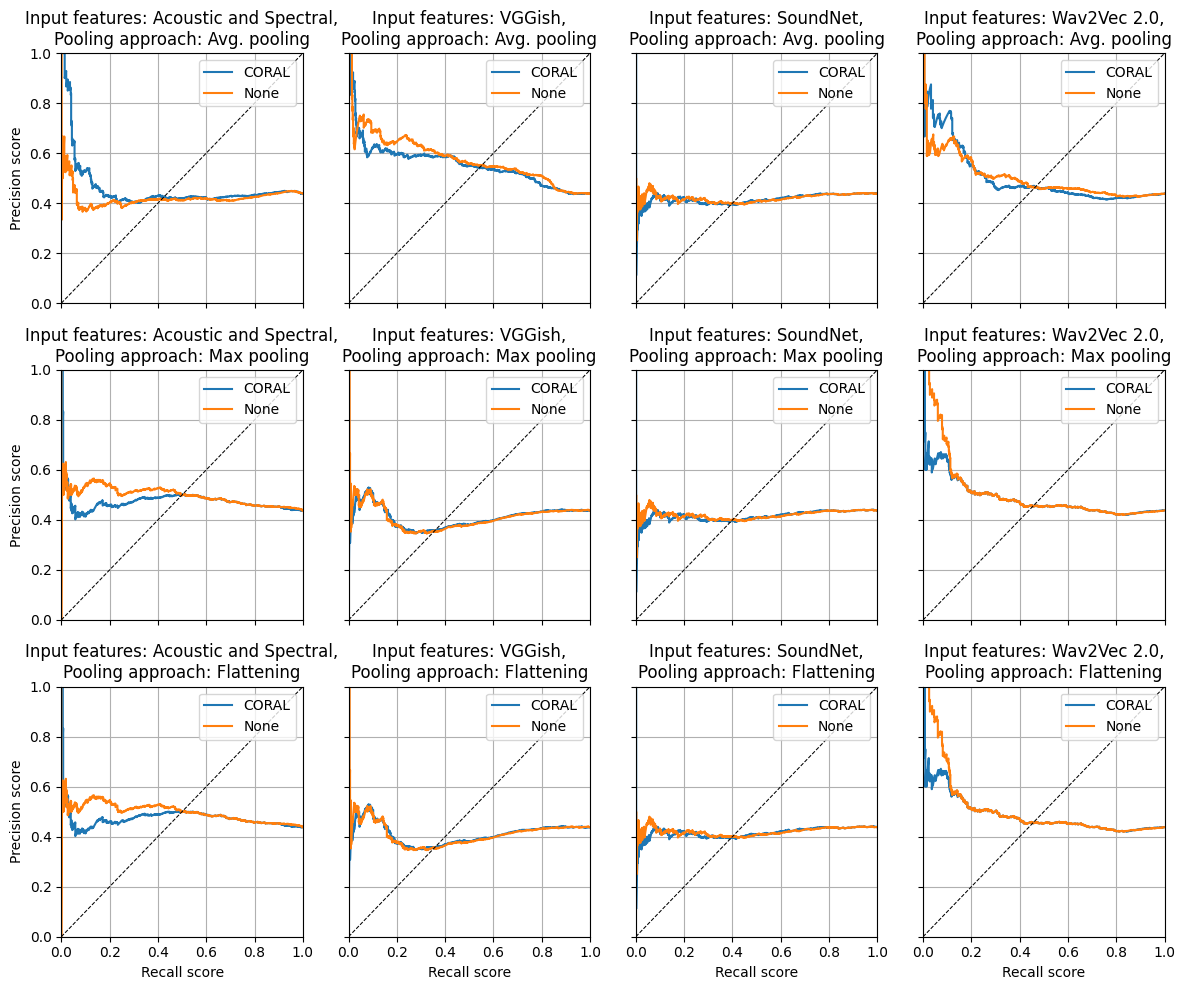

In [86]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        # axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [87]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_pr_curve.pdf'))

### Confusion matrix

In [88]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(CONF_MAT)]
df_no_ad = df_te_to_en[
     (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(CONF_MAT)]


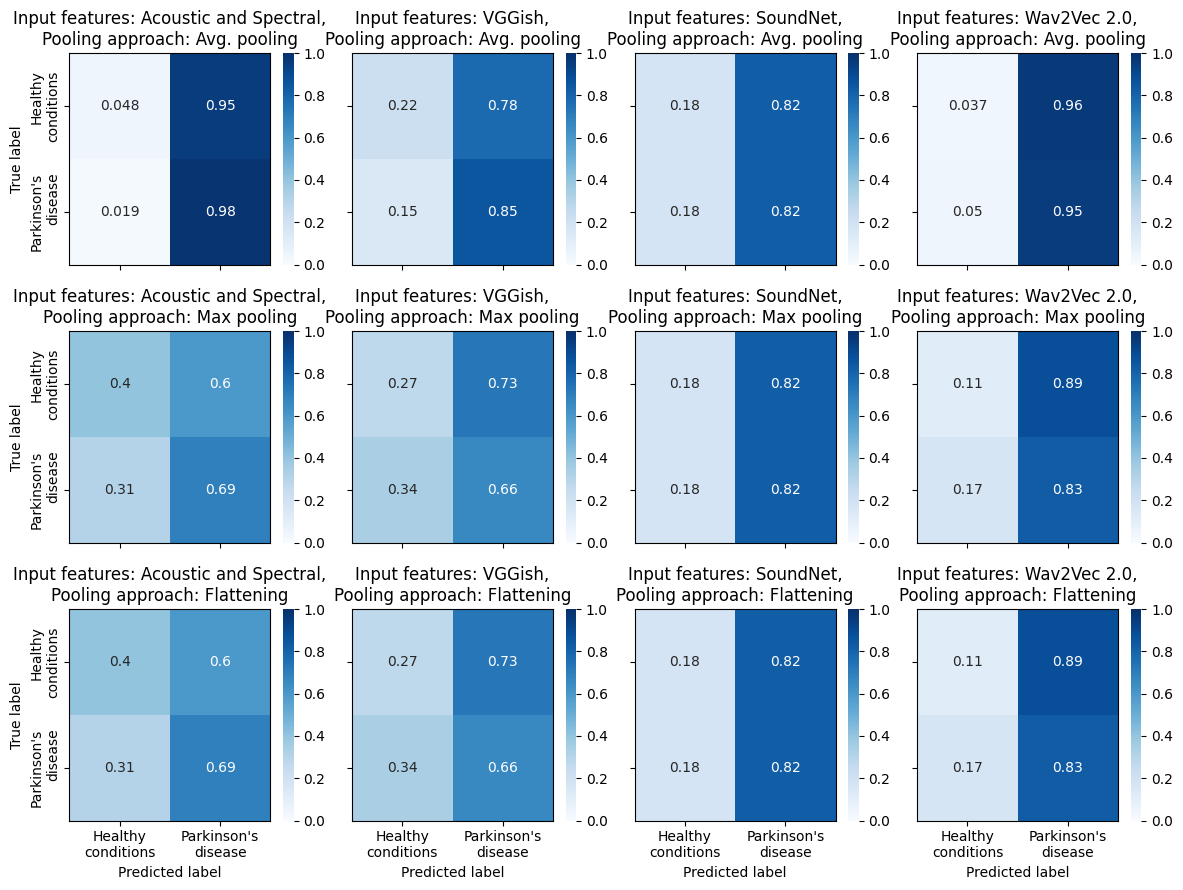

In [89]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [90]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_with_adpt_cm.pdf'))

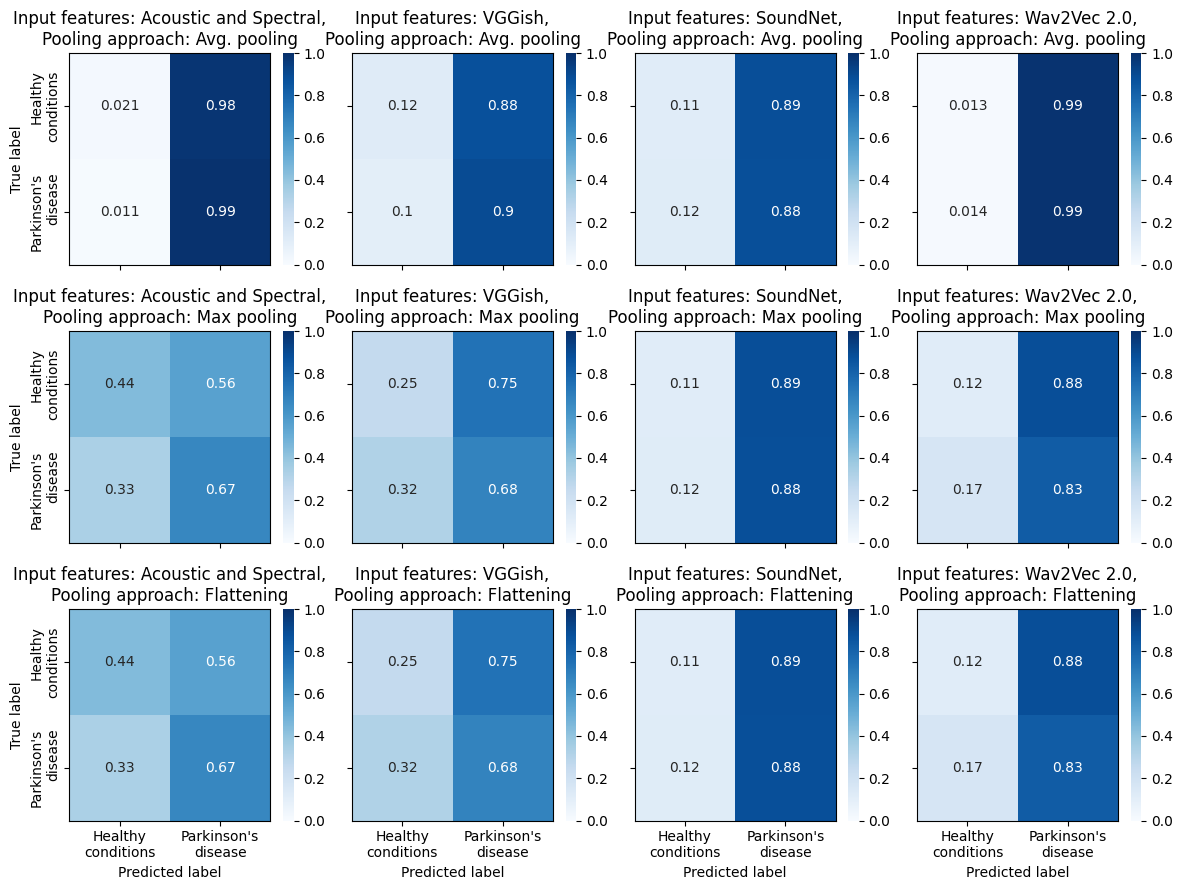

In [91]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [92]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_no_adpt_cm.pdf'))